In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [14]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect =True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [20]:
inspector = inspect(engine)

print("STATION")
columns= inspector.get_columns('station')
for column in columns:
    print(column['name'], column["type"])

print("MEASUREMENT")

columns= inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column["type"])


STATION
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
MEASUREMENT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
formated_latest_date = dt.datetime.strptime(latest_date,"%Y-%m-%d").date()

year_ago = formated_latest_date - dt.timedelta(days=365)

9

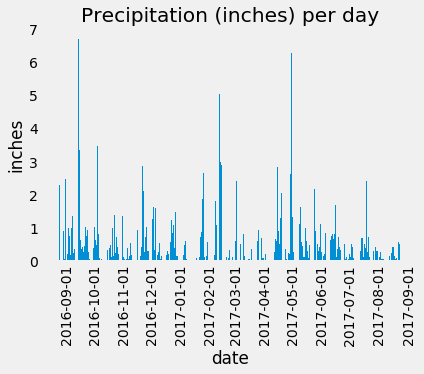

In [27]:
# Design a query to show how many stations are available in this dataset?
one_year_measurement = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).order_by(Measurement.date).all(
)
precipitation_df = pd.DataFrame(one_year_measurement, columns=["Date", "Precipitation"])

# Sort the dataframe by date

precipitation_df = precipitation_df.sort_values(by="Date").set_index("Date")

import matplotlib.dates as mdates

inches = list(precipitation_df["Precipitation"])
date =  list(precipitation_df.index)

axt = plt.gca()
timet = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in date]
formatter = mdates.DateFormatter("%Y-%m-%d")
axt.xaxis.set_major_formatter(formatter)

locator = mdates.MonthLocator()
axt.xaxis.set_major_locator(locator)

Bar = plt.bar(timet,inches)
plt.xlabel("date")
plt.ylabel("inches")
plt.title("Precipitation (inches) per day")
plt.xticks(rotation=90)
plt.grid()
plt.plot()

stations_count = session.query(distinct(Station.station)).count()
stations_count

In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_count = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()[0][0]
most_active_station

'USC00519281'

In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temperature = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()[0][0]

max_temperature = session.query( func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()[0][0]

avg_temperature = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()[0][0]


print(f"The minimun temperature in station {most_active_station} is {min_temperature}")
print(f"The maximum temperature in station {most_active_station} is {max_temperature}")
print(f"The average temperature in station {most_active_station} is {round(avg_temperature, 2)}")

The minimun temperature in station USC00519281 is 54.0
The maximum temperature in station USC00519281 is 85.0
The average temperature in station USC00519281 is 71.66


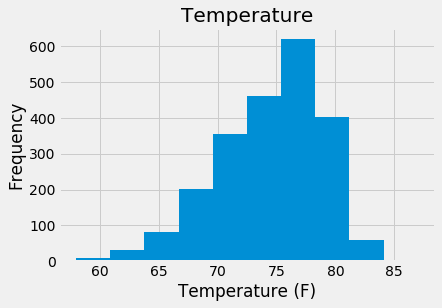

In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_temperature = session.query(Measurement.tobs).\
                    filter(Measurement.date <= formated_latest_date).\
                    filter(Measurement.date >= year_ago).\
                    order_by(Measurement.date).all()

temperature_df = pd.DataFrame(one_year_temperature, columns = ["Temperature"])

temperature_df.hist(column = "Temperature")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
[(tmin, tavg, tmax)] = calc_temps('2017-06-02', '2017-06-12')

print(f"The minimum temperature between the dates is: {tmin}")
print(f"The average temperature between the dates is: {round(tavg, 2)}")
print(f"The maximum temperature between the dates is: {tmax}")

The minimum temperature between the dates is: 72.0
The average temperature between the dates is: 77.46
The maximum temperature between the dates is: 83.0


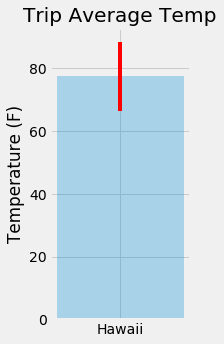

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig,ax = plt.subplots(figsize=(3,5))

ax.bar(np.arange(1), tavg, yerr=tmax-tmin, align='center', alpha=0.3, ecolor='red' )
ax.set_xticks(np.arange(1))

ax.set_xticklabels(['Hawaii'])
ax.set_ylabel("Temperature (F)")
ax.set_title('Trip Average Temp')
plt.tight_layout()
plt.show()

In [39]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(func.sum(Measurement.prcp), Station.name, Station.station, Station.latitude, Station.longitude, Station.elevation).\
                filter(Station.station == Measurement.station).order_by(func.sum(Measurement.prcp)).\
                filter(Measurement.date >= '2017-06-02').\
                filter(Measurement.date <= '2017-06-12').\
                group_by(Station.station).all()
for x in rainfall:
    
    print(f"The total amount of rainfall in {x[1]} station is {x[0]}")

The total amount of rainfall in PEARL CITY, HI US station is None
The total amount of rainfall in WAIKIKI 717.2, HI US station is 0.16
The total amount of rainfall in WAIMANALO EXPERIMENTAL FARM, HI US station is 0.67
The total amount of rainfall in KANEOHE 838.1, HI US station is 1.1300000000000001
The total amount of rainfall in KUALOA RANCH HEADQUARTERS 886.9, HI US station is 1.4100000000000001
The total amount of rainfall in WAIHEE 837.5, HI US station is 1.97
The total amount of rainfall in MANOA LYON ARBO 785.2, HI US station is 2.35


In [40]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
 
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [41]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
i = 0
dates = []
while i < 11: 
    travel_date = dt.date(2017,6,2) + dt.timedelta(days = i)
    dates.append(travel_date.strftime("%m-%d"))
    i = i + 1

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []
for date in dates:
    normals.append(daily_normals(date)[0])
    
print(normals)

[(65.0, 74.4, 81.0), (65.0, 74.03448275862068, 80.0), (65.0, 73.81818181818181, 81.0), (68.0, 74.85454545454546, 81.0), (70.0, 75.17543859649123, 80.0), (68.0, 75.07142857142857, 81.0), (70.0, 75.58620689655173, 81.0), (69.0, 75.15254237288136, 81.0), (68.0, 75.14285714285714, 81.0), (69.0, 76.01960784313725, 84.0), (66.0, 75.66666666666667, 83.0)]


In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vacation_tmp_df = pd.DataFrame(normals, columns = ["Min", "Avg", "Max"])
vacation_tmp_df["Date"] = dates
vacation_tmp_df = vacation_tmp_df.set_index("Date")
vacation_tmp_df

,Min,Avg,Max
Date,,,
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0
06-10,68.0,75.142857,81.0


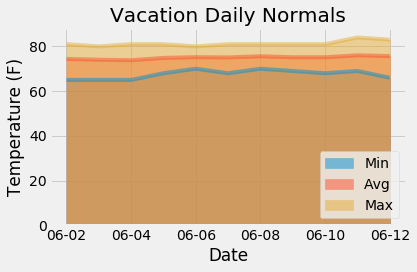

In [48]:
# Plot the daily normals as an area plot with `stacked=False`
vacation_tmp_df.plot(kind='area', stacked=False)
plt.legend(loc='lower right')
plt.ylabel("Temperature (F)")
plt.title("Vacation Daily Normals")
plt.tight_layout()
plt.show()